<a href="https://colab.research.google.com/github/sunny0103/DeepLearning_nlp_projects/blob/main/movie_reviews/movie_reviews_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
cd "/content/drive/MyDrive/Data/movie_reviews"

/content/drive/MyDrive/Data/movie_reviews


In [3]:
!pip install transformers

In [4]:
!pip install gluonnlp mxnet

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import gluonnlp as nlp
import mxnet

from transformers import (AutoModel,
                          AutoTokenizer,
                          AdamW)
from transformers.optimization import get_cosine_schedule_with_warmup
import torch.optim as optim


import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import random
import os

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

# plt.style.use('ggplot')

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


seed_everything(42)
SEED = 42

In [7]:
MODLE_NAME = "klue/bert-base"
tokenizer = AutoTokenizer.from_pretrained(MODLE_NAME)

In [8]:
tokenizer.tokenize("[CLS] 한국어 버트 모델 실습입니다. [SEP]")

['[CLS]', '한국어', '버', '##트', '모델', '실습', '##입니다', '.', '[SEP]']

In [9]:
tokenizer("[CLS] 한국어 버트 모델 실습입니다. [SEP]")

{'input_ids': [2, 2, 9187, 1139, 2265, 4347, 10256, 12190, 18, 3, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [10]:
bert_model = AutoModel.from_pretrained(MODLE_NAME, return_dict=False)
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(32000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [11]:
train = pd.read_csv('./train.csv')
train

,id,document,label
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1
3,4,아무래도 20년도지난작품이라 지금보기는너무유치하다,0
4,5,지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.,0
...,...,...,...
4995,4996,좋은 배우들로 3류영화를 찍은 안타까운 영화,0
4996,4997,진짜 드럽게 재미없다 에드워드 호퍼 그림에 배경 빼고는 볼게 아닌영화,0
4997,4998,가장 실망스러운 영화.. 지금까지 본영화중..,0
4998,4999,"이런 평점 테러, 네이버에서 좀 막아야 하는 것 아닌가?",1


In [12]:
test = pd.read_csv('./test.csv')
test

,id,document
0,1,시간 때우기 좋은 영화 지루함
1,2,훈훈한 정이 느껴지는 영화! 가족끼리 드라마 보듯이 보면 딱~!
2,3,Childhood fantasy
3,4,멋있는 영화입니다. 잊을 수 없는!
4,5,너무 감동적이네요 펑펑 울었습니다
...,...,...
4995,4996,연계도 제대로 안되고 뭔가 부족한느낌이들고 찝찝한영화
4996,4997,내생에 최악의 영화중 하나 졸려서 미칠뻔....
4997,4998,지금까지 나온 드라마 중 최고였습니다. 100점 만점!
4998,4999,영화값으로 엄청난 공연을 보았다 - 이게 웬 횡재 ..


In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(train.index.values,
                                                    train.label.values,
                                                    test_size=0.2,
                                                    random_state = SEED)

In [14]:
train['data_type'] =['not_set'] * train.shape[0]

train.loc[X_train, 'data_type'] = 'train'
train.loc[X_valid, 'data_type'] = 'valid'
train.head()

,id,document,label,data_type
0,1,영상이나 음악이 이쁘다 해도 미화시킨 불륜일뿐,0,train
1,2,히치콕이 이 영화를 봤다면 분명 박수를 쳤을듯...,1,train
2,3,괜찮은 음악영화가 또 나왔군요!!! 따뜻한 겨울이 될 것 같아요~,1,train
3,4,아무래도 20년도지난작품이라 지금보기는너무유치하다,0,train
4,5,지금까지의 영화들이 그랬듯. 이 영화역시 일본에 대한 미화는 여전하다.,0,train


In [15]:
# split train valid dataset
train_set = train[train.data_type == 'train']
valid_set = train[train.data_type == 'valid']

In [16]:
# # split train valid dataset
# train_set = train[train.data_type == 'train'].sample(n=2000)
# valid_set = train[train.data_type == 'valid'].sample(n=500)

In [17]:
train_set = train_set.reset_index(drop=True)
valid_set = valid_set.reset_index(drop=True)
test_set = test.reset_index(drop=True)

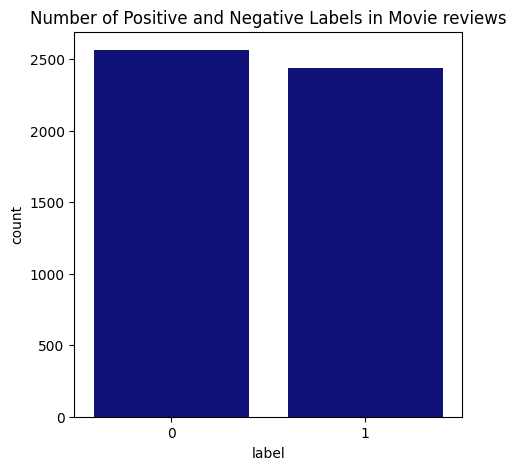

In [18]:
plt.figure(figsize=(5,5))
sns.countplot(train, x='label', color='darkblue')
plt.title('Number of Positive and Negative Labels in Movie reviews')
plt.show()

In [19]:
max_len = 64

class CustomDataset(Dataset):
  def __init__(self, dataset, tokenizer, train_mode=True):
    self.dataset = dataset
    self.tokenizer = tokenizer
    self.train_mode = train_mode

  def __getitem__(self, index):
    text = self.dataset.loc[index, 'document']

    inputs = self.tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        max_length=max_len,
        padding='max_length',
        add_special_tokens=True
    )
    input_ids = inputs['input_ids'][0]
    token_type_ids = inputs['token_type_ids'][0]
    attention_mask = inputs['attention_mask'][0]

    if self.train_mode:
      label = self.dataset.loc[index, 'label']
      return input_ids, token_type_ids, attention_mask, label
    return input_ids, token_type_ids, attention_mask

  def __len__(self):
    return len(self.dataset)

In [20]:
train_dataset = CustomDataset(train_set, tokenizer, train_mode=True)
valid_dataset = CustomDataset(valid_set, tokenizer, train_mode=True)
test_dataset = CustomDataset(test_set, tokenizer, train_mode=False)

In [21]:
BATCH_SIZE = 16

trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
testdloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [22]:
# for idx, batch in enumerate(trainloader):
#   print(batch)
#   if idx==2:
#     break

In [23]:
class BERTClassifier(nn.Module):
  def __init__(
    self,
    bert,
    hidden_size = 768,
    num_classes=2,
    dropout=None,
    params=None
  ):
    super(BERTClassifier, self).__init__()
    self.bert = bert
    self.dropout = dropout

    self.classifier = nn.Linear(hidden_size, num_classes)

    if dropout:
      self.dropout = nn.Dropout(p=dropout)

  def forward(self, input_ids, token_type_ids, attention_mask):
    _, pooler = self.bert(input_ids = input_ids, token_type_ids = token_type_ids.long(), attention_mask = attention_mask.float())

    if self.dropout:
      output = self.dropout(pooler)
    else:
      output = pooler

    predicted = self.classifier(output)

    return predicted

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu' )

In [25]:
warmup_ratio = 0.1
num_epochs = 2
max_grad_norm = 1
learning_rate =  5e-5

In [26]:
dropout_rate = 0.2

model = BERTClassifier(bert_model, dropout=dropout_rate).to(device)

In [27]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [28]:
optimizer = AdamW(optimizer_grouped_parameters, lr = learning_rate)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [29]:
total_steps = len(trainloader) * num_epochs
warmup_step = int(total_steps * warmup_ratio)

In [30]:
scheduler = get_cosine_schedule_with_warmup(optimizer,
                                            num_warmup_steps=warmup_step,
                                            num_training_steps=total_steps)

In [31]:
def accuracy_metric(predictions, true_vals):
  max_vals, max_indicies = torch.max(predictions, 1)
  accuracy = (max_indicies == true_vals).sum().data.cpu().numpy()/max_indicies.size()[0]
  return accuracy

In [32]:
def plot_confusion_matrix(c_matrix, labels, title='Confusion Matrix', cmap=plt.cm.get_cmap('Blues')):

  plt.imshow(c_matrix, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  marks = np.arange(len(labels))
  nlabels = []

  for k in range(len(c_matrix)):
      n = sum(c_matrix[k])
      nlabel = '{0}(n={1})'.format(labels[k],n)
      nlabels.append(nlabel)

  plt.xticks(marks, labels)
  plt.yticks(marks, nlabels)

  thresh = c_matrix.max() / 2.

  for i, j in itertools.product(range(c_matrix.shape[0]), range(c_matrix.shape[1])):
    plt.text(j, i, c_matrix[i, j], horizontalalignment="center", color="white" if c_matrix[i, j] > thresh else "black")

  plt.figure(figsize=(7,7))
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

<ipython-input-32-7b55083ceb7f>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  def plot_confusion_matrix(c_matrix, labels, title='Confusion Matrix', cmap=plt.cm.get_cmap('Blues')):


In [33]:
class Trainer():
  def __init__(self, trainloader, validloader, testdloader,  model, optimizer, criterion, scheduler, device):
    self.trainloader = trainloader
    self.validloader  = validloader
    self.testdloader = testdloader
    self.model = model
    self.optimizer = optimizer
    self.criterion = criterion
    self.scheduler = scheduler
    self.device = device

  def train(self, epochs = 1):
    self.model.train()


    for epoch in range(1, epochs+1):
      train_acc = 0.0
      running_loss =0.0
      print("==================Epoch {}/{}==================".format(epoch, epochs))
      for batch_idx, batch in tqdm(enumerate(self.trainloader)):
        batch = tuple(b.to(self.device) for b in batch)
        inputs = {'input_ids':batch[0],
                  'token_type_ids':batch[1],
                  'attention_mask':batch[2]}
        label = batch[3]

        self.optimizer.zero_grad()
        predict = self.model(**inputs)
        loss = self.criterion(predict, label)
        running_loss += loss.item()
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        self.optimizer.step()
        self.scheduler.step()

        train_acc += accuracy_metric(predict, label)

      train_loss = running_loss/len(trainloader)
      self.validate()
      print('Train Loss: {:.4f}, Train Accuracy:{:.4f} '.format(train_loss, train_acc/(batch_idx+1)))

  def validate(self):
    self.model.eval()
    valid_acc = 0.0
    predictions, true_vals =[], []

    with torch.no_grad():
      running_loss = 0.0
      for batch_idx, batch in tqdm(enumerate(self.validloader)):
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids':batch[0],
              'token_type_ids':batch[1],
              'attention_mask':batch[2]}
        label = batch[3]

        predict = model(**inputs)
        valid_acc += accuracy_metric(predict, label)

      predicted_label = torch.max(predict, 1)[1]
      true_vals +=label.tolist()
      predictions += predicted_label.tolist()

    print('Validation accuracy:{:.4f}'.format(valid_acc/(batch_idx+1)))

    # valid_confusion_matrix = confusion_matrix(predictions, true_vals)
    # plot_confusion_matrix(valid_confusion_matrix,labels=["negative", "positive"])

  def test(self):
    self.model.eval()
    predictions = []
    with torch.no_grad():
      for batch in tqdm(self.testdloader):
        batch = tuple(b.to(self.device) for b in batch)
        inputs = {'input_ids':batch[0],
                  'token_type_ids':batch[1],
                  'attention_mask':batch[2]}
        predict = model(**inputs)

        predict_label = torch.max(predict, 1)[1]
        predictions += predict_label.tolist()
    return predictions


In [34]:
trainer = Trainer(trainloader= trainloader,
                  validloader = validloader,
                  testdloader = testdloader,
                  model = model,
                  optimizer = optimizer,
                  criterion = criterion,
                  scheduler = scheduler,
                  device = device)
trainer.train(epochs=num_epochs)

==================Epoch 1/2==================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation accuracy:0.9117
Train Loss: 0.3267, Train Accuracy:0.8628 
==================Epoch 2/2==================


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Validation accuracy:0.9206
Train Loss: 0.0840, Train Accuracy:0.9745 


In [40]:
pred = trainer.test()

  0%|          | 0/313 [00:00<?, ?it/s]

In [41]:
submission = pd.read_csv('./sample_submission.csv')

In [42]:
submission['label'] = pred

In [43]:
submission

,id,label
0,1,0
1,2,1
2,3,1
3,4,1
4,5,1
...,...,...
4995,4996,0
4996,4997,0
4997,4998,1
4998,4999,0


In [44]:
submission.to_csv('./submit_bert.csv', index=False)